# Eda - Grupo 2

## Importando as bibliotecas necessárias

In [147]:
import numpy as np
import pandas as pd
import geopandas as gpd
import re
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
sns.color_palette("crest", as_cmap=True)
sns.set(style='darkgrid')
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})

from tqdm import tqdm
tqdm.pandas(desc="my bar!")

## Tables

In [148]:
df = pd.read_pickle('../datasets/processed/movies.pkl')
df.head()

,title,rating,year,month,certificate,runtime,directors,stars,genre,filming_location,budget,income,country_of_origin
0,Avatar: The Way of Water,8.0,2022,December,PG-13,192,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...","Action, Adventure, Fantasy",New Zealand,350000000.0,681081686.0,United States
1,Guillermo del Toro's Pinocchio,7.8,2022,December,PG,117,"Guillermo del Toro, Mark Gustafson","Ewan McGregor, David Bradley, Gregory Mann, Bu...","Animation, Drama, Family",USA,35000000.0,71614.0,"United States, Mexico, France"
2,Bullet Train,7.3,2022,August,R,127,David Leitch,"Brad Pitt, Joey King, Aaron Taylor Johnson, Br...","Action, Comedy, Thriller",Japan,85900000.0,239268602.0,"Japan, United States"
3,The Banshees of Inisherin,8.0,2022,November,R,114,Martin McDonagh,"Colin Farrell, Brendan Gleeson, Kerry Condon, ...","Comedy, Drama",Ireland,40000000.0,19720823.0,"Ireland, United Kingdom, United States"
4,M3gan,6.7,2022,January,PG-13,102,Gerard Johnstone,"Jenna Davis, Amie Donald, Allison Williams, Vi...","Horror, Sci-Fi, Thriller",New Zealand,40000000.0,90776006.5,United States


In [149]:
df_oscar = pd.read_pickle("../datasets/processed/the_oscar_award.pkl")
df_oscar.rename(columns={'year_film': 'year', 'film': 'title'}, inplace=True)
df_oscar.head()

#Pega os filmes que ganharam Oscar a partir de 2003
df_oscar_2003_up = df_oscar.loc[(df_oscar['year']>= 2003) & (df_oscar['winner']==True)]

#Pega os filmes que ganharam Oscar de melhor FILME a partir de 2003
df_oscar_2003_up_best_picture = df_oscar_2003_up.loc[(df_oscar_2003_up['category'] == 'BEST PICTURE')]

#Cria um DataSeries de quantidade de Oscars' recebidos
df_group_oscar_2003_up_prize_quantity = df_oscar_2003_up.groupby(['title']).size().reset_index()

#Cria títulos para colunas
df_group_oscar_2003_up_prize_quantity.columns = ["title", "oscars"]

#Junta as df's => df + df_oscar_2003_up
df = df.merge(df_oscar_2003_up, how="inner", on=["title", "year"])

In [150]:
def classification_of_runtime(x: int) -> str:
    if x < 60:
        return 'short'
    elif x < 120:
        return 'medium'
    elif x < 180:
        return 'long'
    else:
        return 'eternity'

df['time_classification'] = df.runtime.progress_apply(classification_of_runtime)
del classification_of_runtime

my bar!: 100%|██████████| 318/318 [00:00<00:00, 274498.59it/s]


In [151]:
df['profit'] = df.income - df.budget
df['proportional_profit'] = np.round(df.income/df.budget*100, 2)
df['budget_per_million'] = df['budget'] / 1_000_000
df['income_per_million'] = df['income'] / 1_000_000

In [152]:
def classification_of_profit(x: int) -> str:
    if x < 0:
        return 'failure'
    else:
        return 'gain'

df['profit_classification'] = df.profit.progress_apply(classification_of_profit)

my bar!: 100%|██████████| 318/318 [00:00<00:00, 515175.23it/s]


In [153]:
df.profit_classification.value_counts()

gain       304
failure     14
Name: profit_classification, dtype: int64

In [154]:
df.describe()

,rating,year,runtime,budget,income,year_ceremony,ceremony,profit,proportional_profit,budget_per_million,income_per_million
count,318.000000,318.000000,318.000000,3.180000e+02,3.180000e+02,318.000000,318.000000,3.180000e+02,318.000000,318.000000,318.000000
mean,7.798742,2012.106918,130.081761,7.317294e+07,3.897495e+08,2013.106918,85.106918,3.165765e+08,811.181667,73.172937,389.749454
std,0.525259,5.462913,24.237643,6.488812e+07,4.169900e+08,5.462913,5.462913,3.769907e+08,1047.231586,64.888118,416.989957
min,5.800000,2003.000000,86.000000,1.500000e+05,2.710090e+05,2004.000000,76.000000,-3.972899e+07,0.680000,0.150000,0.271009
25%,7.500000,2007.000000,115.000000,1.910000e+07,1.065105e+08,2008.000000,80.000000,7.753565e+07,309.930000,19.100000,106.510535
50%,7.800000,2012.000000,126.000000,4.000000e+07,2.323491e+08,2013.000000,85.000000,1.858028e+08,523.030000,40.000000,232.349092
75%,8.100000,2017.000000,143.000000,1.100000e+08,5.270163e+08,2018.000000,90.000000,4.233558e+08,938.670000,110.000000,527.016307
max,9.000000,2021.000000,201.000000,2.500000e+08,2.922918e+09,2022.000000,94.000000,2.685918e+09,13957.810000,250.000000,2922.917914


In [155]:
df.describe(exclude=['float64', 'uint16', 'uint32', 'uint8'])

,title,month,certificate,directors,stars,genre,filming_location,country_of_origin,category,name,winner,time_classification,profit_classification
count,318,318,318,318,318,318,318,318,318,318,318,318,318
unique,167,12,5,125,167,63,39,66,25,293,1,3,2
top,The Lord of the Rings: The Return of the King,December,R,Peter Jackson,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...","Action, Adventure, Drama",USA,United States,CINEMATOGRAPHY,Emmanuel Lubezki,True,long,gain
freq,11,90,144,14,11,26,136,108,19,3,318,192,304


In [156]:
def list_of_str(array: np.ndarray) -> pd.DataFrame:
    new_df = pd.Series(np.sum((array) + ',').split(',')).str.strip()
    test = new_df.copy()
    new_df = pd.DataFrame(list(set(new_df)), columns=[array.name])
    new_df.drop(index=new_df[new_df[array.name] == ''].index, inplace=True)
    new_df.reset_index(drop=True, inplace=True)
    new_df['frequency'] = [test.str.fullmatch(item).sum() for item in tqdm(new_df[array.name].values)]
    new_df['rating'] = [df[df[array.name].str.contains(item)]['rating'].mean() for item in tqdm(new_df[array.name].values)]
    new_df['year'] = [df[df[array.name].str.contains(item)]['year'].values for item in tqdm(new_df[array.name].values)]
    new_df['runtime'] = [df[df[array.name].str.contains(item)]['runtime'].mean() for item in tqdm(new_df[array.name].values)]
    new_df['profit'] = [df[df[array.name].str.contains(item)]['profit'].mean() for item in tqdm(new_df[array.name].values)]
    new_df['profit_classification'] = [df[df[array.name].str.contains(item)]['profit_classification'].mode()[0] for item in tqdm(new_df[array.name].values)]
    
    return new_df

In [157]:
list_of_directors = list_of_str(df.directors)

100%|██████████| 139/139 [00:00<00:00, 1870.02it/s]


In [158]:
list_of_directors.sort_values('frequency', ascending=False).head(10)

,directors,frequency,rating,year,runtime,profit,profit_classification
136,Martin Scorsese,14,7.785714,"[2011, 2011, 2011, 2011, 2011, 2006, 2006, 200...",148.857143,1.073838e+08,gain
79,Peter Jackson,14,8.614286,"[2005, 2005, 2005, 2003, 2003, 2003, 2003, 200...",198.000000,9.019110e+08,gain
66,Christopher Nolan,11,8.409091,"[2020, 2017, 2017, 2017, 2014, 2010, 2010, 201...",139.363636,5.818247e+08,gain
60,Damien Chazelle,10,8.080000,"[2018, 2016, 2016, 2016, 2016, 2016, 2016, 201...",122.700000,2.832366e+08,gain
74,Alfonso Cuar n,10,7.700000,"[2018, 2018, 2018, 2013, 2013, 2013, 2013, 201...",104.200000,4.419772e+08,gain
70,David Fincher,9,7.577778,"[2020, 2020, 2011, 2010, 2010, 2010, 2008, 200...",142.000000,1.507043e+08,gain
99,Denis Villeneuve,9,7.988889,"[2021, 2021, 2021, 2021, 2021, 2021, 2017, 201...",152.666667,2.014463e+08,gain
63,Alejandro G I rritu,8,7.787500,"[2015, 2015, 2015, 2014, 2014, 2014, 2014, 2006]",135.875000,2.056303e+08,gain
85,Clint Eastwood,8,7.925000,"[2014, 2006, 2004, 2004, 2004, 2004, 2003, 2003]",134.750000,1.935722e+08,gain
28,Loveleen Tandan,8,8.000000,"[2008, 2008, 2008, 2008, 2008, 2008, 2008, 2008]",120.000000,3.634105e+08,gain


In [159]:
list_of_stars = list_of_str(df.stars)

100%|██████████| 503/503 [00:00<00:00, 2178.52it/s]


In [160]:
list_of_stars.sort_values('frequency', ascending=False).head(10)

,stars,frequency,rating,year,runtime,profit,profit_classification
45,Leonardo DiCaprio,20,8.095000,"[2015, 2015, 2015, 2013, 2013, 2012, 2012, 201...",156.500000,3.187617e+08,gain
153,Viggo Mortensen,14,8.828571,"[2018, 2018, 2018, 2003, 2003, 2003, 2003, 200...",185.785714,8.909495e+08,gain
352,Orlando Bloom,12,8.858333,"[2006, 2003, 2003, 2003, 2003, 2003, 2003, 200...",196.833333,1.034851e+09,gain
99,Tom Hardy,12,8.000000,"[2017, 2017, 2017, 2015, 2015, 2015, 2015, 201...",125.500000,3.388724e+08,gain
258,Elijah Wood,12,8.783333,"[2006, 2003, 2003, 2003, 2003, 2003, 2003, 200...",193.250000,9.884476e+08,gain
318,Ian McKellen,11,9.000000,"[2003, 2003, 2003, 2003, 2003, 2003, 2003, 200...",201.000000,1.052458e+09,gain
266,Cate Blanchett,10,7.570000,"[2013, 2008, 2008, 2008, 2006, 2004, 2004, 200...",158.900000,1.267443e+08,gain
25,Ryan Gosling,10,7.910000,"[2018, 2017, 2017, 2016, 2016, 2016, 2016, 201...",136.700000,3.035058e+08,gain
19,Matt Damon,10,8.110000,"[2019, 2019, 2007, 2007, 2007, 2006, 2006, 200...",138.100000,2.108013e+08,gain
411,George Clooney,10,7.530000,"[2013, 2013, 2013, 2013, 2013, 2013, 2013, 201...",99.900000,4.805559e+08,gain


In [161]:
df.groupby('time_classification').agg({
    'rating': ['mean', 'median']
})

rating       
                         mean median
time_classification                 
eternity             8.614286    9.0
long                 7.792708    7.8
medium               7.707143    7.8

In [162]:
df.groupby('year').agg({
    'rating': ['mean', 'median', 'sum'], 
    'runtime': ['mean', 'median', 'sum'],
    'profit': ['mean', 'median', 'sum']
})

rating                   runtime                     profit  \
          mean median    sum        mean median   sum          mean   
year                                                                  
2003  8.421053   9.00  160.0  169.894737  201.0  3228  6.878417e+08   
2004  7.776471   7.70  132.2  140.000000  132.0  2380  1.965401e+08   
2005  7.350000   7.30  102.9  146.285714  139.5  2048  1.886584e+08   
2006  7.829412   7.90  133.1  128.764706  123.0  2189  1.602478e+08   
2007  7.846667   8.00  117.7  119.800000  119.0  1797  1.847869e+08   
2008  7.937500   8.00  127.0  130.750000  120.0  2092  3.307584e+08   
2009  7.854545   7.80   86.4  130.909091  129.0  1440  9.144739e+08   
2010  7.863158   8.00  149.4  120.473684  118.0  2289  4.637420e+08   
2011  7.583333   7.50   91.0  123.000000  126.0  1476  8.819654e+07   
2012  7.650000   7.70  153.0  137.950000  136.0  2759  3.621930e+08   
2013  7.705000   7.70  154.1  112.250000  109.5  2245  4.059140e+08   
2014  8.000000   8.00  136.0  117.411765  114.0  1996  1.784880e+08   
2015  7.900000   8.10  142.2  131.444444  124.5  2366  2.598526e+08   
2016  7.635000   7.85  152.7  124.250000  128.0  2485  3.449299e+08   
2017  7.682353   7.70  130.6  122.529412  123.0  2083  2.396167e+08   
2018  7.721053   7.70  146.7  132.263158  134.0  2513  4.567512e+08   
2019  8.058824   8.20  137.0  126.058824  122.0  2143  3.213881e+08   
2020  7.523077   7.40   97.8  113.230769  107.0  1472  4.072224e+07   
2021  7.658824   8.00  130.2  139.117647  155.0  2365  1.285879e+08   

                                  
            median           sum  
year                              
2003  1.052458e+09  1.306899e+10  
2004  1.037199e+08  3.341182e+09  
2005  1.614304e+08  2.641218e+09  
2006  9.305895e+07  2.724213e+09  
2007  1.466274e+08  2.771803e+09  
2008  3.634105e+08  5.292134e+09  
2009  2.802317e+08  1.005921e+10  
2010  4.123743e+08  8.811098e+09  
2011  7.324746e+07  1.058359e+09  
2012  3.400288e+08  7.243861e+09  
2013  2.486599e+08  8.118281e+09  
2014  1.087267e+08  3.034295e+09  
2015  2.652614e+08  4.677346e+09  
2016  4.412272e+08  6.898597e+09  
2017  1.759333e+08  4.073484e+09  
2018  2.987527e+08  8.678273e+09  
2019  2.512761e+08  5.463598e+09  
2020  3.445821e+07  5.293892e+08  
2021  1.335032e+08  2.185995e+09

In [163]:
df.groupby('year')[
    [
        'month', 'certificate', 
        'directors', 'filming_location', 
        'profit_classification'
    ]
].agg(lambda x: x.mode()[0])

,month,certificate,directors,filming_location,profit_classification
year,,,,,
2003,December,PG-13,Peter Jackson,New Zealand,gain
2004,December,PG-13,Martin Scorsese,USA,gain
2005,December,PG-13,Ang Lee,USA,gain
2006,October,R,Martin Scorsese,USA,gain
2007,November,R,"Ethan Coen, Joel Coen",USA,gain
2008,December,R,"Danny Boyle, Loveleen Tandan",India,gain
2009,May,PG-13,James Cameron,USA,gain
2010,December,R,Christopher Nolan,USA,gain
2011,November,PG,Martin Scorsese,UK,gain


In [164]:
pd.DataFrame(zip(
    df.certificate.value_counts(), 
    df.certificate.value_counts(normalize=True)
    ), index=df.certificate.value_counts().index, columns=['count', 'percentage'])

,count,percentage
R,144,0.452830
PG-13,131,0.411950
PG,35,0.110063
G,5,0.015723
Unrated,3,0.009434
NC-17,0,0.000000
TV-14,0,0.000000
TV-G,0,0.000000
TV-MA,0,0.000000
TV-PG,0,0.000000


In [165]:
pd.DataFrame(zip(
    df.filming_location.value_counts(), 
    df.filming_location.value_counts(normalize=True)
    ), index=df.filming_location.value_counts().index, columns=['count', 'percentage'])

,count,percentage
USA,136,0.427673
UK,40,0.125786
New Zealand,19,0.059748
Canada,15,0.047170
India,12,0.037736
...,...,...
Guatemala,0,0.000000
Guam,0,0.000000
Greece,0,0.000000
Georgia,0,0.000000


In [166]:
pd.DataFrame(zip(
    df.month.value_counts(), 
    df.month.value_counts(normalize=True)
    ), index=df.month.value_counts().index, columns=['count', 'percentage'])

,count,percentage
December,90,0.283019
November,75,0.235849
October,43,0.135220
January,30,0.094340
August,16,0.050314
February,15,0.047170
May,15,0.047170
March,12,0.037736
July,10,0.031447
June,9,0.028302


In [167]:
df.query('profit == @df.profit.min() | profit == @df.profit.max()')

,title,rating,year,month,certificate,runtime,directors,stars,genre,filming_location,...,ceremony,category,name,winner,time_classification,profit,proportional_profit,budget_per_million,income_per_million,profit_classification
11,The Power of the Dog,6.8,2021,December,R,126,Jane Campion,"Benedict Cumberbatch, Kirsten Dunst, Jesse Ple...","Drama, Romance, Western",New Zealand,...,94,DIRECTING,Jane Campion,True,long,-3.972899e+07,0.68,40.0,0.271009,failure
209,Avatar,7.8,2009,December,PG-13,162,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...","Action, Adventure, Fantasy",USA,...,82,ART DIRECTION,Production Design: Rick Carter and Robert Stro...,True,long,2.685918e+09,1233.30,237.0,2922.917914,gain
210,Avatar,7.8,2009,December,PG-13,162,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...","Action, Adventure, Fantasy",USA,...,82,CINEMATOGRAPHY,Mauro Fiore,True,long,2.685918e+09,1233.30,237.0,2922.917914,gain
211,Avatar,7.8,2009,December,PG-13,162,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...","Action, Adventure, Fantasy",USA,...,82,VISUAL EFFECTS,"Joe Letteri, Stephen Rosenbaum, Richard Baneha...",True,long,2.685918e+09,1233.30,237.0,2922.917914,gain


In [168]:
df.query('proportional_profit == @df.proportional_profit.min() | proportional_profit == @df.proportional_profit.max()')

,title,rating,year,month,certificate,runtime,directors,stars,genre,filming_location,...,ceremony,category,name,winner,time_classification,profit,proportional_profit,budget_per_million,income_per_million,profit_classification
11,The Power of the Dog,6.8,2021,December,R,126,Jane Campion,"Benedict Cumberbatch, Kirsten Dunst, Jesse Ple...","Drama, Romance, Western",New Zealand,...,94,DIRECTING,Jane Campion,True,long,-39728991.0,0.68,40.00,0.271009,failure
250,Once,7.8,2007,June,R,86,John Carney,"Glen Hansard, Mark ta Irglov , Hugh Walsh, Ger...","Drama, Music, Romance",Ireland,...,80,MUSIC (Original Song),Music and Lyric by Glen Hansard and Marketa Ir...,True,medium,20786722.0,13957.81,0.15,20.936722,gain


In [169]:
# df.sort_values('profit', ascending=False).head(10)
# df.sort_values('proportional_profit', ascending=False).head(10)
# df.sort_values('rating', ascending=False).head(10)
# df.sort_values('rating', ascending=True).head(10)

In [170]:
pd.DataFrame(df.query('profit_classification == "failure" & rating >= 7').title.values, columns=['title'])

,title
0,CODA
1,CODA
2,CODA
3,West Side Story
4,King Richard
5,Drive My Car
6,Promising Young Woman
7,Another Round
8,Marriage Story
9,Roma


In [171]:
pd.DataFrame(zip(
    df.query('profit_classification == "failure"').year.value_counts(sort=False), 
    df.query('profit_classification == "failure" & rating >= 7').year.value_counts(sort=False)
    ), index=df.query('profit_classification == "failure" & rating >= 7').year.unique(), columns=['failure', 'failure_and_positive_rating'])

,failure,failure_and_positive_rating
2021,7,6
2020,2,2
2019,1,1
2018,3,3


In [172]:
bins = [0.1, 5 ,10, 25, 50, 100, 150, 200, 250, float('inf')]
labels = ['0.1-5', '5-10','10-25', '25-50', '50-100', '100-150', '150-200', '200-250', '250+']
df['budget_range'] = pd.cut(df['budget_per_million'], bins=bins, labels=labels)

budget_counts = df['budget_range'].value_counts(normalize=True) * 100

print(budget_counts)

10-25      25.157233
50-100     18.867925
25-50      16.666667
100-150    13.207547
150-200    11.320755
0.1-5       6.603774
5-10        5.031447
200-250     3.144654
250+        0.000000
Name: budget_range, dtype: float64


In [173]:
# Função para análise entre duas colunas com tratamento dos dados

def analise_2colunas(df_coluna_1, df_coluna_2, colunas):
    date_1 = df_coluna_1.str.split(", ")
    df_1 = [term for lis in date_1 for term in lis]
    df_2 = [term for idx_2, term in enumerate(df_coluna_2) for x in range(len(date_1[idx_2]))]
    df = pd.DataFrame(list(zip(df_1, df_2)), columns = colunas)
    return df.copy()
    
# Diretores pelas avaliações
director_for_rating = analise_2colunas(df['directors'], df['rating'], ['director', 'rating'])

In [174]:
director_for_rating = director_for_rating.groupby(['director'], as_index = False).agg(mean = ('rating', 'mean'))
directors = director_for_rating.sort_values('mean', ascending=False).head(10)

In [175]:
# As melhores médias de direção

directors

,director,mean
99,Peter Jackson,8.614286
16,Bong Joon Ho,8.500000
29,Christopher Nolan,8.409091
14,Bob Persichetti,8.400000
1,Adrian Molina,8.400000
46,Florian Henckel von Donnersmarck,8.400000
130,Todd Phillips,8.400000
100,Peter Ramsey,8.400000
107,Rodney Rothman,8.400000
82,Lee Unkrich,8.320000


In [176]:
#ganhadores de melhores filmes a partir de 2003
array_oscar_2003_up_best_picture = np.array(df_oscar_2003_up_best_picture['title'].unique())

#ganhadores de melhores filmes a partir de 2003 pelo df do IMDB
df_merge_best_picture = df_merge.loc[df_merge['category']== 'BEST PICTURE']

array_df_merge_best_picture = np.array(df_merge_best_picture["title"].unique())

#print(f"ARRAY 1 {array_oscar_2003_up_best_picture}\nARRAY 2 {array_df_merge_best_picture}")

#Descobrir os filmes faltantes no dataset do IMDB que ganharam o Oscar de melhor filme
array_resultado = np.setdiff1d(array_oscar_2003_up_best_picture, array_df_merge_best_picture)

print(f'RESULTADO {array_resultado}')

RESULTADO ['Crash' 'The Artist' 'The Hurt Locker']


In [177]:
'''
O por quê de ser um outlier - Número de Oscars? | Popularidade? | Qualidade?
'''

'''
No Rotten Tomatoes
-------------------------------------------------------------------------------------

INCEPTION                                     => 87% TOMATOMETER & 91% AUDIENCE SCORE

THE DARK KNIGHT RISES                         => 87% TOMATOMETER & 90% AUDIENCE SCORE

THE LORD OF THE RINGS: THE RETURN OF THE KING => 93% TOMATOMETER & 86% AUDIENCE SCORE
'''

'\nNo Rotten Tomatoes\n-------------------------------------------------------------------------------------\n\nINCEPTION                                     => 87% TOMATOMETER & 91% AUDIENCE SCORE\n\nTHE DARK KNIGHT RISES                         => 87% TOMATOMETER & 90% AUDIENCE SCORE\n\nTHE LORD OF THE RINGS: THE RETURN OF THE KING => 93% TOMATOMETER & 86% AUDIENCE SCORE\n'

In [178]:
# Descobrimos o outlier

outlier = df.loc[df['rating']> 8.75]

print(outlier['title'].unique())

['Inception' 'The Dark Knight'
 'The Lord of the Rings: The Return of the King']


## Plots

In [179]:
def create_bar(df_: pd, ax_: plt.axes, x_: str, y_: str, agg_: str, title_:str, rot=45):
    df = df_.groupby(by=x_, as_index=False)[y_].agg(agg_)
    try:
        df[x_] = df[x_].str.capitalize()
    except:
        pass
    
    if x_ in 'month':
        order_ = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
        sns.barplot(data=df, x=x_, y=y_, ax=ax_, order=order_, palette="crest")
    else:
        sns.barplot(data=df, x=x_, y=y_, ax=ax_, palette="crest")
    
    
    for value in ax_.containers:
        ax_.bar_label(value)
    ax_.tick_params(axis='x', labelrotation=rot, size=12)
    ax_.tick_params(axis='y', size=12)
    ax_.set_xlabel(x_.capitalize(), fontsize='large', family='monospace')
    ax_.set_ylabel(y_.capitalize(), fontsize='large', family='monospace')
    ax_.set_title(title_.title(), fontsize='large', fontweight='bold', 
            style='italic', family='monospace')
    
def create_box(df: pd, ax_: plt.axes, x_: str, y_: str, title_:str, rot=45):
    try:
        df[x_] = df[x_].str.capitalize()
    except:
        pass
    
    if x_ in 'month':
        order_ = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
        sns.boxplot(data=df, x=x_, y=y_, ax=ax_, order=order_, palette="crest")
    else:
        sns.boxplot(data=df, x=x_, y=y_, ax=ax_, palette="crest")
    
    ax_.tick_params(axis='x', labelrotation=rot, size=12)
    ax_.tick_params(axis='y', size=12)
    ax_.set_xlabel(x_.capitalize(), fontsize='large', family='monospace')
    ax_.set_ylabel(y_.capitalize(), fontsize='large', family='monospace')
    ax_.set_title(title_.title(), fontsize='large', fontweight='bold', 
            style='italic', family='monospace')
    
def create_scatter(df: pd, ax_: plt.axes, x_: str, y_: str, hue_: str, title_: str):
    sns.scatterplot(data=df, x=x_, y=y_, hue=hue_, size=hue_, alpha = 0.75, ax=ax_)
    ax_.set_xlabel(x_.capitalize(), fontsize='large', family='monospace')
    ax_.set_ylabel(y_.capitalize(), fontsize='large', family='monospace')
    ax_.set_title(title_.title(), fontsize='large', fontweight='bold', 
            style='italic', family='monospace')

In [189]:
# Plotando gráfico
genre_for_year = analise_2colunas(df['genre'], df['year'], ['genre', 'year'])
genre_for_year = genre_for_year.groupby(['genre', 'year'], as_index = False).agg(count = ('genre', 'count'))

fig = px.line(genre_for_year, x = 'year',y ='count',
              color = 'genre',
              title='Relação da quantidade de filmes por generos e ano')
fig.update_xaxes(dtick="M1")
fig.show()

In [190]:
# Genero por orçamento

genre_for_budget = analise_2colunas(df['genre'], df['budget'], ['genre', 'budget'])
genre_for_budget = genre_for_budget.groupby('genre', as_index = False).agg(mean = ('budget', 'mean'))

# Plotando gráfico

fig = px.histogram(genre_for_budget, x = 'genre', y ='mean', 
                   color_discrete_sequence= ['#37AA9C'])
fig.update(layout_title_text='Média do orçamento por gênero')
fig.show()

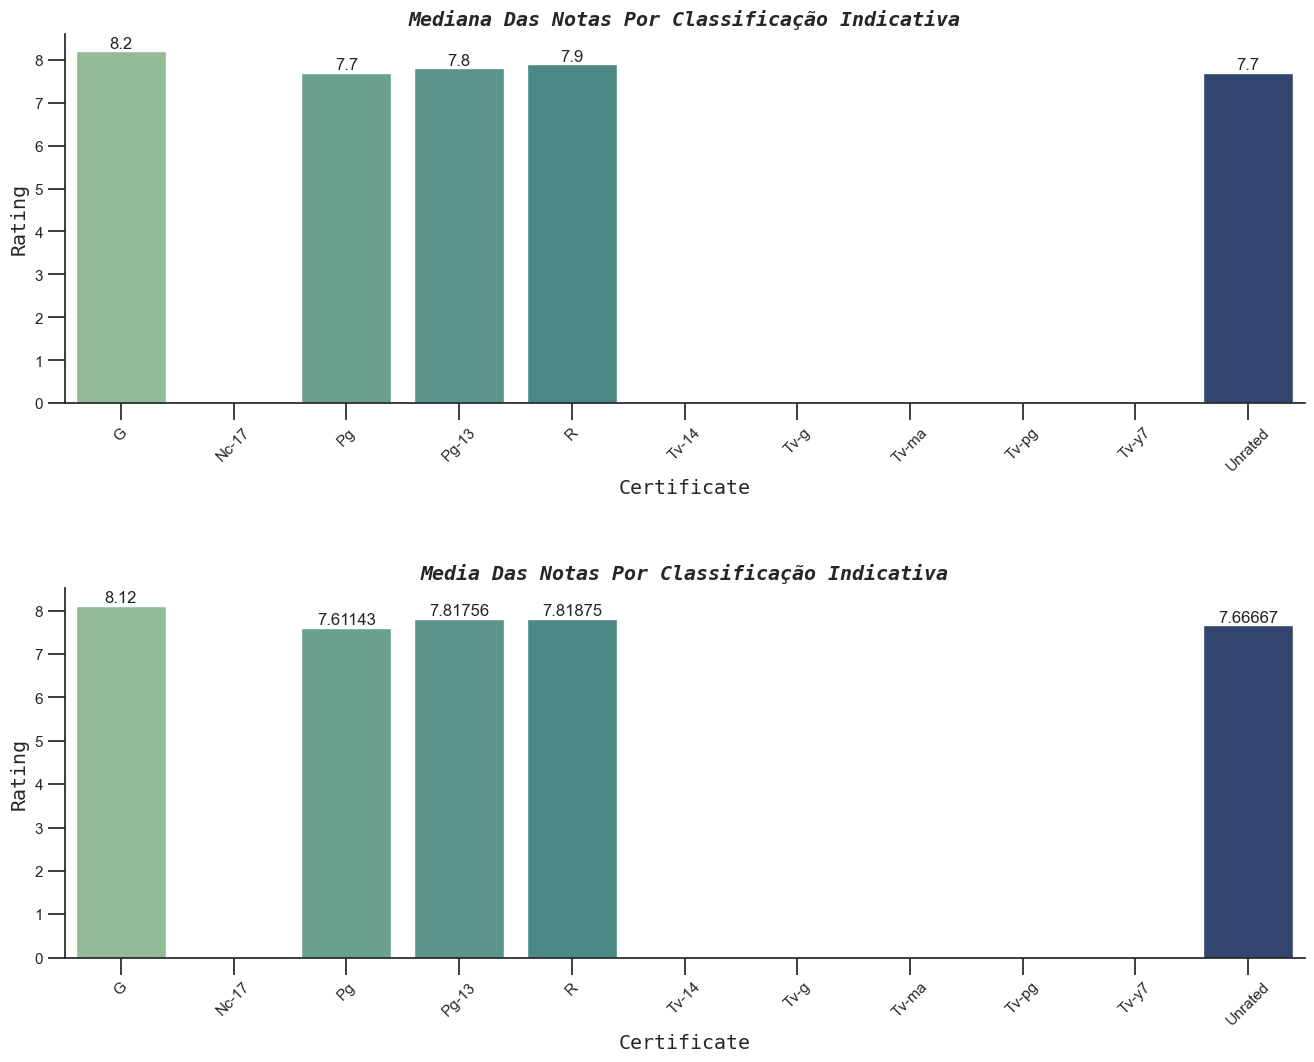

In [180]:
fig, (ax1, ax2) = plt.subplots((2), figsize=(16, 12))
create_bar(df, ax1, 'certificate', 'rating', 'median', 'Mediana das notas por classificação indicativa')
create_bar(df, ax2, 'certificate', 'rating', 'mean', 'Media das notas por classificação indicativa')
plt.subplots_adjust(hspace=.5)
plt.show()

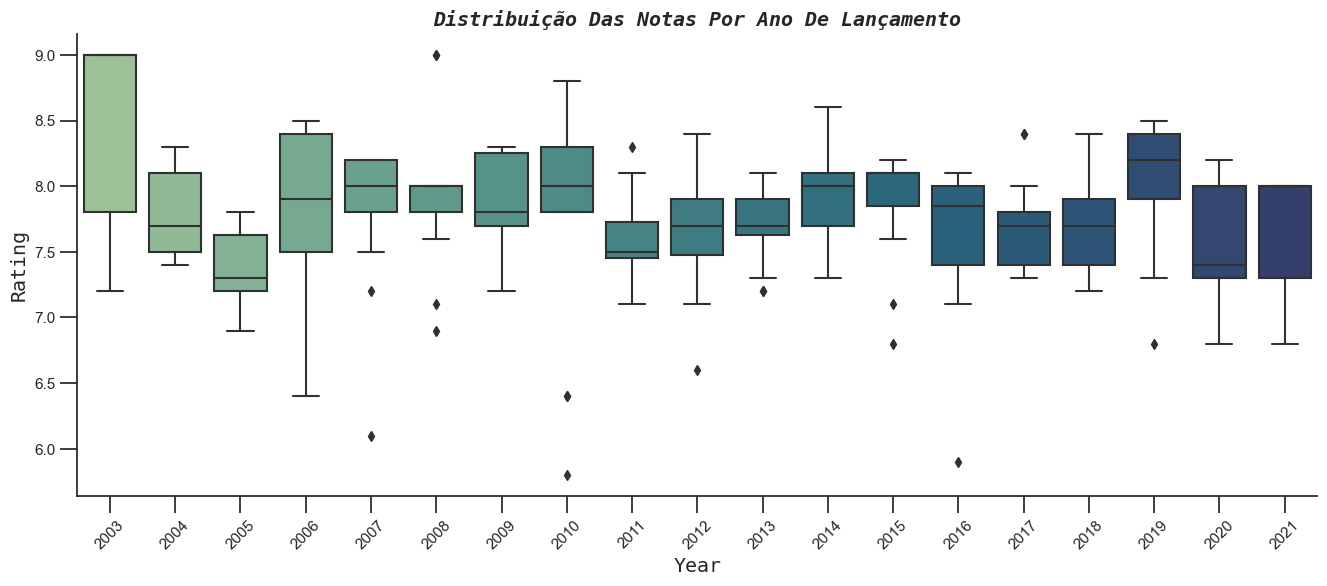

In [181]:
fig, ax = plt.subplots(figsize=(16, 6))
create_box(df, ax, 'year', 'rating', 'Distribuição das notas por ano de lançamento')
plt.show()

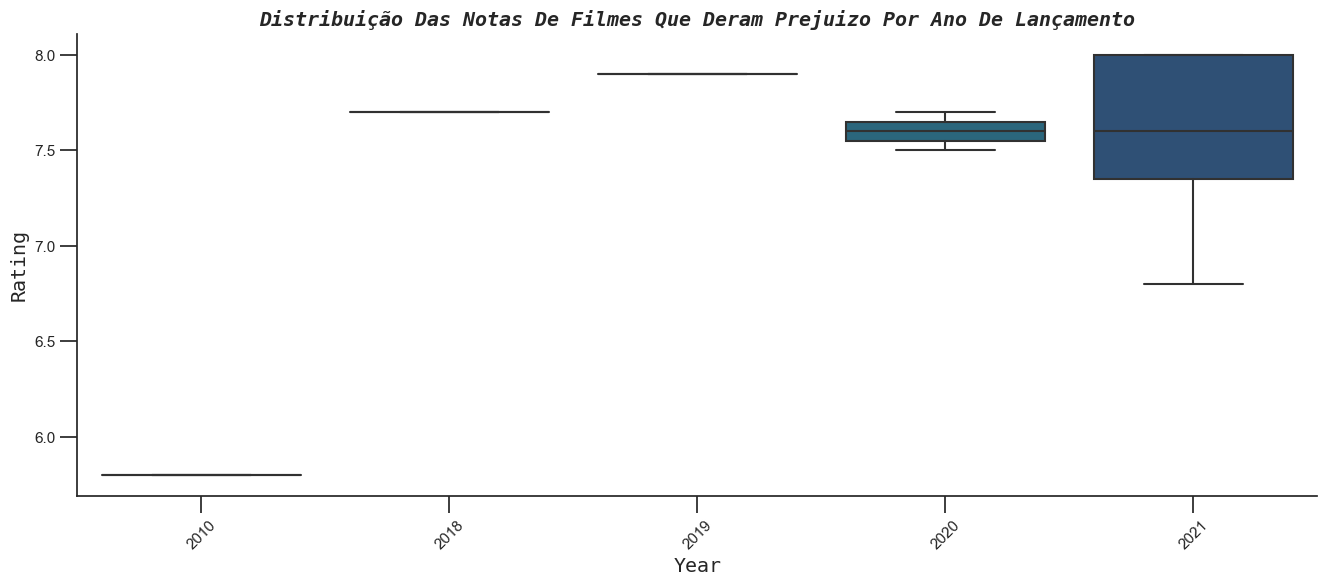

In [182]:
fig, ax = plt.subplots(figsize=(16, 6))
create_box(df.query('profit_classification == "failure"'), ax, 'year', 'rating', 'Distribuição das notas de filmes que deram prejuizo por ano de lançamento')
plt.show()

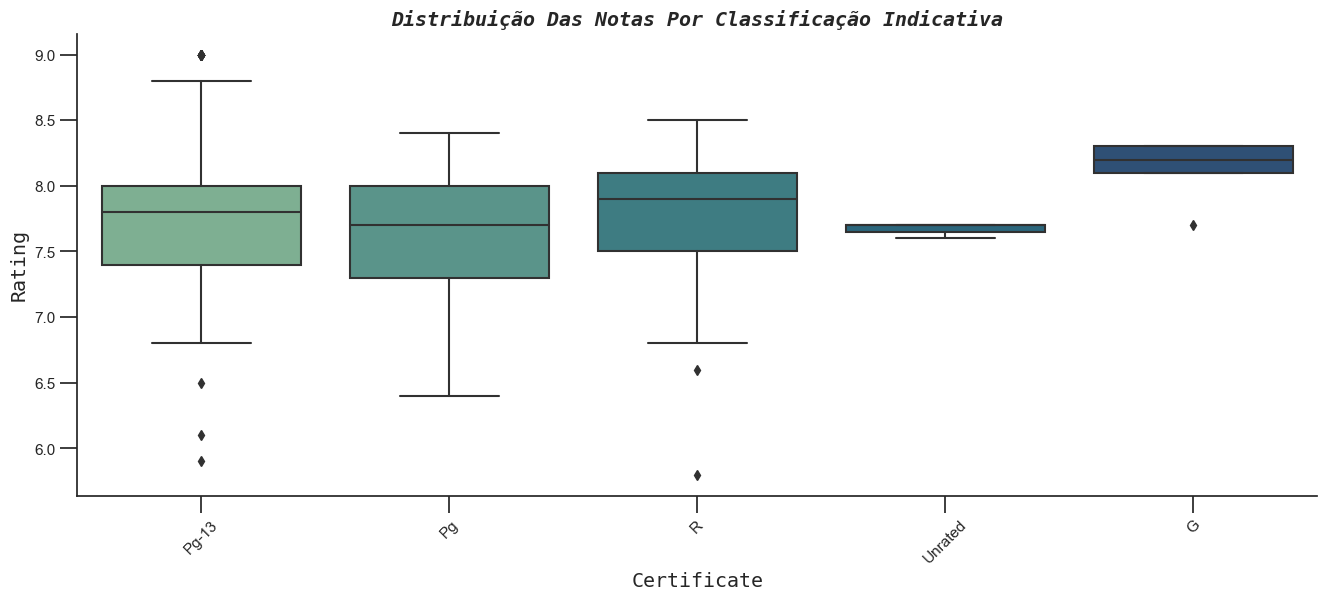

In [183]:
fig, ax = plt.subplots(figsize=(16, 6))
create_box(df, ax, 'certificate', 'rating', 'Distribuição das notas por classificação indicativa')
plt.show()

In [184]:
df.time_classification.unique()

array(['long', 'medium', 'eternity'], dtype=object)

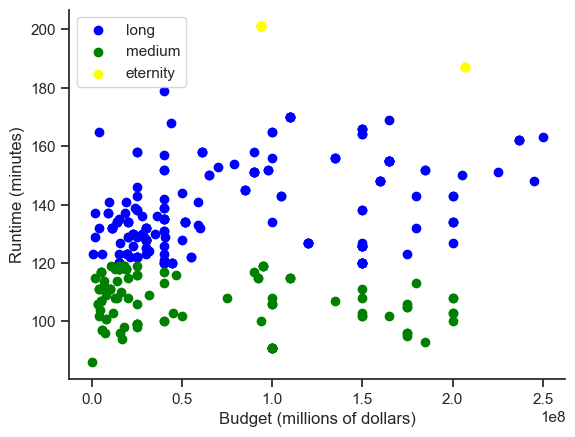

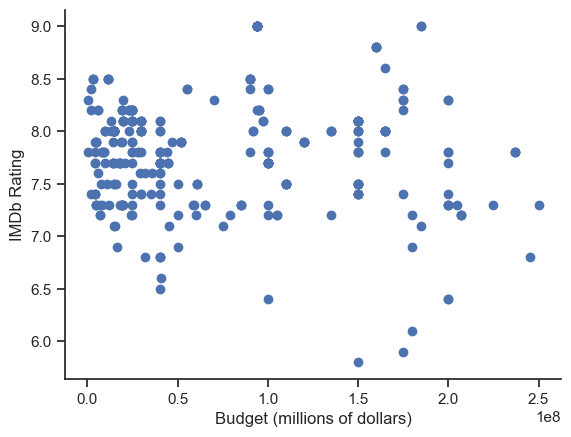

In [186]:
# Plote um gráfico de dispersão com cada grupo de tempo de execução em uma cor diferente
colors = {'long': 'blue', 'medium': 'green', 'eternity': 'yellow'}
for time_classification, color in colors.items():
    plt.scatter(df[df['time_classification'] == time_classification]['budget'], df[df['time_classification'] == time_classification]['runtime'], c=color, label=time_classification)

plt.xlabel('Budget (millions of dollars)')
plt.ylabel('Runtime (minutes)')
plt.legend()
plt.show()

plt.scatter(df['budget'], df['rating'])
plt.xlabel('Budget (millions of dollars)')
plt.ylabel('IMDb Rating')
plt.show()

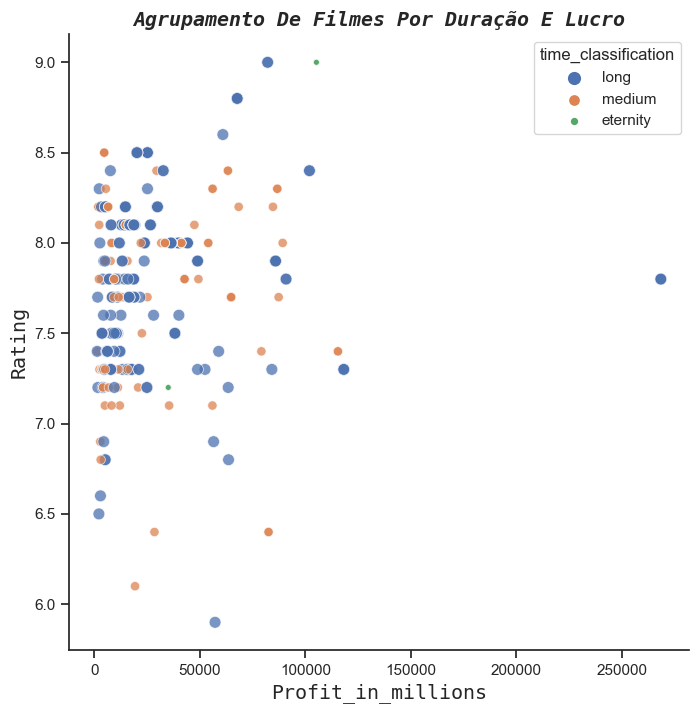

In [136]:
fig, ax = plt.subplots(figsize=(8, 8))

df_to_scatter = df.query('profit_classification == "gain"').copy()
df_to_scatter['profit_in_millions'] = df_to_scatter.profit/10_000
create_scatter(df_to_scatter, ax, 'profit_in_millions', 'rating', 'time_classification', 'Agrupamento de filmes por duração e lucro')
del df_to_scatter

plt.show()

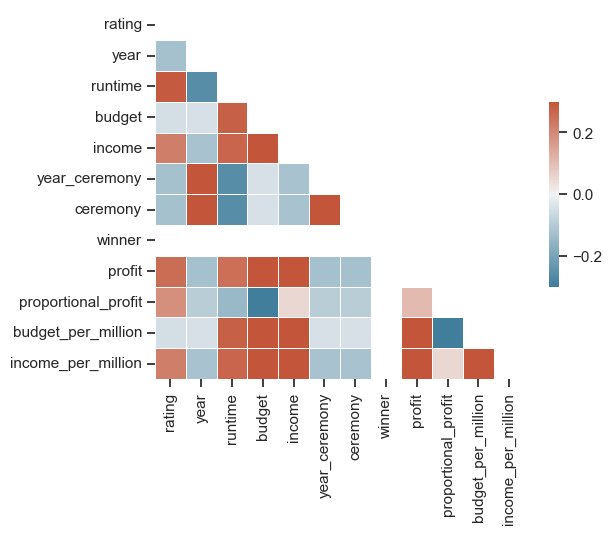

In [137]:
corr = df.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [142]:
corr

,rating,year,runtime,budget,income,year_ceremony,ceremony,winner,profit,proportional_profit,budget_per_million,income_per_million
rating,1.000000,-0.128909,0.289372,-0.048134,0.222265,-0.128909,-0.128909,NaN,0.254133,0.189447,-0.048134,0.222265
year,-0.128909,1.000000,-0.259254,-0.045421,-0.122601,1.000000,1.000000,NaN,-0.127792,-0.095341,-0.045421,-0.122601
runtime,0.289372,-0.259254,1.000000,0.276877,0.269243,-0.259254,-0.259254,NaN,0.250153,-0.148913,0.276877,0.269243
budget,-0.048134,-0.045421,0.276877,1.000000,0.664674,-0.045421,-0.045421,NaN,0.563076,-0.300883,1.000000,0.664674
income,0.222265,-0.122601,0.269243,0.664674,1.000000,-0.122601,-0.122601,NaN,0.991697,0.049567,0.664674,1.000000
year_ceremony,-0.128909,1.000000,-0.259254,-0.045421,-0.122601,1.000000,1.000000,NaN,-0.127792,-0.095341,-0.045421,-0.122601
ceremony,-0.128909,1.000000,-0.259254,-0.045421,-0.122601,1.000000,1.000000,NaN,-0.127792,-0.095341,-0.045421,-0.122601
winner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
profit,0.254133,-0.127792,0.250153,0.563076,0.991697,-0.127792,-0.127792,NaN,1.000000,0.106614,0.563076,0.991697
proportional_profit,0.189447,-0.095341,-0.148913,-0.300883,0.049567,-0.095341,-0.095341,NaN,0.106614,1.000000,-0.300883,0.049567


## Georef

In [138]:
gdf = gpd.read_file('../datasets/georef/world_countries.shp')[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf.head()

,country,country_code,geometry
0,Fiji,FJI,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,United Republic of Tanzania,TZA,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Western Sahara,SAH,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [139]:
rating = analise_2colunas(df['country_of_origin'], df['rating'], ['country', 'rating'])
rating = rating.groupby(['country'], as_index = False).agg(mean = ('rating', 'mean'))
rating.loc[rating['country'] == 'United States',  'country'] = 'United States of America'
rating.head()

,country,mean
0,Argentina,8.200000
1,Australia,7.766667
2,Belgium,7.100000
3,Brazil,7.800000
4,Canada,7.839286


In [140]:
merged = gdf.merge(rating, on = 'country')
merged_json = json.loads(merged.to_json())
json_data = json.dumps(merged_json)
merged.head()

,country,country_code,geometry,mean
0,Canada,CAN,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",7.839286
1,United States of America,USA,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",7.781356
2,Argentina,ARG,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...",8.200000
3,Kenya,KEN,"POLYGON ((39.20222 -4.67677, 37.76690 -3.67712...",7.400000
4,Norway,NOR,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80...",7.800000


In [141]:
geosource = GeoJSONDataSource(geojson = json_data)
palette = brewer['YlGnBu'][8]
palette = palette[::-1]
color_mapper = LinearColorMapper(palette = palette)

color_bar = ColorBar(color_mapper = color_mapper,
                     label_standoff = 8,
                     width = 500,
                     height = 20,
                     border_line_color = None,
                     location = (0,0),
                     orientation = 'horizontal')

mapa = figure(title = 'Média das avaliações de acordo com os países de origem',
           height = 450,
           width = 850,
           toolbar_location = None)

mapa.xgrid.grid_line_color = None
mapa.ygrid.grid_line_color = None

mapa.patches('xs',
          'ys',
          source = geosource,
          fill_color = {'field' :'mean','transform' : color_mapper},
          line_color = 'black',
          line_width = 0.25,
          fill_alpha = 1)

mapa.add_layout(color_bar, 'below')
output_notebook()
show(mapa)

Loading BokehJS ...